In [1]:
import warnings
import sys
sys.path.append('..')
warnings.filterwarnings('ignore')
import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.model_selection import KFold
from scipy.stats import spearmanr 
from tqdm import tqdm

In [2]:
tissue = 'Tonsil'
adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'
adata.layers['counts'] = adata.X
pdata.layers['counts'] = pdata.X
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(4194, 18046)

In [3]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()
sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)
type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
from utils import featurize
from sklearn.decomposition import PCA

gex = featurize(adata)
pex = featurize(pdata)
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()
# corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
# pca1 = PCA(n_components=2048).fit(d11)
# pca2 = PCA(n_components=28).fit(d12)
# d11_pca = pca1.transform(d11)
# d12_pca = pca2.transform(d12)
# d11 = torch.tensor(d11_pca).cuda()
# d12 = torch.tensor(d12_pca).cuda()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
d11.shape, d12.shape

((4194, 18003), (4194, 28))

In [9]:
from modules.grace import GRACE, drop_feature
import torch.nn.functional as F
from torch_geometric.utils import dropout_adj
from sklearn.preprocessing import MinMaxScaler

In [15]:
import math
import os
import torch
import random
import gudhi
import anndata
import cmcrameri
import numpy as np
import scanpy as sc
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from torch_geometric.nn import GCNConv, DeepGraphInfomax
from sklearn.neighbors import kneighbors_graph
from SpaceFlow.util import sparse_mx_to_torch_edge_list, corruption

class SpaceFlow(object):
    """An object for analysis of spatial transcriptomics data.

    :param adata: the `anndata.AnnData` object as input, see `https://anndata.readthedocs.io/en/latest/` for more info about`anndata`.
    :type adata: class:`anndata.AnnData`
    :param count_matrix: count matrix of gene expression, 2D numpy array of size (n_cells, n_genes)
    :type count_matrix: class:`numpy.ndarray`
    :param spatial_locs: spatial locations of cells (or spots) match to rows of the count matrix, 1D numpy array of size (n_cells,)
    :type spatial_locs: class:`numpy.ndarray`
    :param sample_names: list of sample names in 1D numpy str array of size (n_cells,), optional
    :type sample_names: class:`numpy.ndarray` or `list` of `str`
    :param gene_names: list of gene names in 1D numpy str array of size (n_genes,), optional
    :type gene_names: class:`numpy.ndarray` or `list` of `str`

    """

    def __init__(self, adata=None, count_matrix=None, spatial_locs=None, sample_names=None, gene_names=None):
        """
        Inputs
        ------
        adata: an anndata.AnnData type object, optional (either input `adata` or both `count_matrix` and `spatial_locs`)
        count_matrix : count matrix of gene expression, 2D numpy array of size (n_cells, n_genes)
        spatial_locs : spatial locations of cells (or spots) match to rows of the count matrix, 1D numpy array of size (n_cells,)
        sample_names : list of sample names in 1D numpy str array of size (n_cells,), optional
        gene_names : list of gene names in 1D numpy str array of size (n_genes,), optional
        """
        if adata and isinstance(adata, anndata.AnnData):
            self.adata = adata
        elif count_matrix is not None and spatial_locs is not None:
            self.adata = anndata.AnnData(count_matrix.astype(float))
            self.adata.obsm['spatial'] = spatial_locs.astype(float)
            if gene_names:
                self.adata.var_names = np.array(gene_names).astype(str)
            if sample_names:
                self.adata.obs_names = np.array(sample_names).astype(str)
        else:
            print("Please input either an anndata.AnnData or both the count_matrix (count matrix of gene expression, 2D int numpy array of size (n_cells, n_genes)) and spatial_locs (spatial locations of cells (or spots) in 1D float numpy array of size (n_locations,)) to initiate SpaceFlow object.")
            exit(1)

    def plt_setting(self, fig_title_sz=30, font_sz=12, font_weight="bold", axes_title_sz=12, axes_label_sz=12, xtick_sz=10, ytick_sz=10, legend_font_sz=10):
        """
        Setting the plotting configuration
        :param fig_title_sz: fontsize of the figure title, default: 30
        :type fig_title_sz: int, optional
        :param font_sz: controls default text sizes, default: 12
        :type font_sz: int, optional
        :param font_weight: controls default text weights, default: 'bold'
        :type font_weight: str, optional
        :param axes_title_sz: fontsize of the axes title, default: 12
        :type axes_title_sz: int, optional
        :param axes_label_sz: fontsize of the x and y labels, default 12
        :type axes_label_sz: int, optional
        :param xtick_sz: fontsize of the x tick label, default 10
        :type xtick_sz: int, optional
        :param ytick_sz: fontsize of the y tick label, default 10
        :type ytick_sz: int, optional
        :param legend_font_sz: legend fontsize, default 10
        :type legend_font_sz: int, optional
        """
        plt.rc('figure', titlesize=fig_title_sz)  # fontsize of the figure title
        plt.rc('font', size=font_sz, weight=font_weight)  # controls default text sizes
        plt.rc('axes', titlesize=axes_title_sz)  # fontsize of the axes title
        plt.rc('axes', labelsize=axes_label_sz)  # fontsize of the x and y labels
        plt.rc('xtick', labelsize=xtick_sz)  # fontsize of the x tick label
        plt.rc('ytick', labelsize=ytick_sz)  # fontsize of the y tick label
        plt.rc('legend', fontsize=legend_font_sz)  # legend fontsize

    def prepare_figure(self, rsz=4., csz=4., wspace=.4, hspace=.5, left=0.125, right=0.9, bottom=0.1, top=0.9):
        fig, axs = plt.subplots(1, 1, figsize=(csz, rsz))
        plt.subplots_adjust(wspace=wspace, hspace=hspace, left=left, right=right, bottom=bottom, top=top)
        return fig, axs

    def preprocessing_data(self, n_top_genes=None, n_neighbors=10):
        adata = self.adata
        if not adata:
            print("No annData object found, please run SpaceFlow.SpaceFlow(expr_data, spatial_locs) first!")
            return
        
        # sc.pp.normalize_total(adata, target_sum=1e4)
        
        
#         featurelog = np.log2(adata.X+1/2)
#         scaler = MinMaxScaler()
#         featurelog = np.transpose(scaler.fit_transform(np.transpose(featurelog)))

        # sc.pp.log1p(adata)
        
        adata.X = d11
        
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes = n_top_genes,
            subset = False,
            layer = "counts",
            flavor = 'seurat_v3'
        )

        
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='cell_ranger', subset=True)
        
        sc.pp.pca(adata)
        spatial_locs = adata.obsm['spatial']
        spatial_graph = self.graph_alpha(spatial_locs, n_neighbors=n_neighbors)

        self.adata_preprocessed = adata
        self.spatial_graph = spatial_graph
        

    def graph_alpha(self, spatial_locs, n_neighbors=10):
        """
        Construct a geometry-aware spatial proximity graph of the spatial spots of cells by using alpha complex.
        """
        A_knn = kneighbors_graph(spatial_locs, n_neighbors=n_neighbors, mode='distance')
        estimated_graph_cut = A_knn.sum() / float(A_knn.count_nonzero())
        spatial_locs_list = spatial_locs.tolist()
        n_node = len(spatial_locs_list)
        alpha_complex = gudhi.AlphaComplex(points=spatial_locs_list)
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=estimated_graph_cut ** 2)
        skeleton = simplex_tree.get_skeleton(1)
        initial_graph = nx.Graph()
        initial_graph.add_nodes_from([i for i in range(n_node)])
        for s in skeleton:
            if len(s[0]) == 2:
                initial_graph.add_edge(s[0][0], s[0][1])

        extended_graph = nx.Graph()
        extended_graph.add_nodes_from(initial_graph)
        extended_graph.add_edges_from(initial_graph.edges)

        # Remove self edges
        for i in range(n_node):
            try:
                extended_graph.remove_edge(i, i)
            except:
                pass

        return nx.to_scipy_sparse_matrix(extended_graph, format='csr')

    def train(self, embedding_save_filepath="./embedding.tsv", spatial_regularization_strength=0.1, z_dim=50, lr=1e-3, epochs=1000, max_patience=50, min_stop=100, random_seed=42, 
              gpu=0, regularization_acceleration=True, edge_subset_sz=1000000):
        adata_preprocessed, spatial_graph = self.adata_preprocessed, self.spatial_graph

        if not adata_preprocessed:
            print("The data has not been preprocessed, please run preprocessing_data() method first!")
            return
        torch.manual_seed(random_seed)
        random.seed(random_seed)
        np.random.seed(random_seed)

        device = f"cuda:{gpu}" if torch.cuda.is_available() else 'cpu'

        model = DeepGraphInfomax(
            hidden_channels=z_dim, encoder=GraphEncoder(adata_preprocessed.shape[1], z_dim),
            summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
            corruption=corruption).to(device)
        
        
        # model = GRACE(adata_preprocessed.shape[1], z_dim, z_dim, latent_dim=z_dim).to(device)
        
        
        expr = adata_preprocessed.X.todense() if type(adata_preprocessed.X).__module__ != np.__name__ else adata_preprocessed.X
        expr = torch.tensor(expr).float().to(device)
        edge_list = sparse_mx_to_torch_edge_list(spatial_graph).to(device)

        model.train()
        min_loss = np.inf
        patience = 0
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        best_params = model.state_dict()
        
        with tqdm(total=epochs) as pbar:

            for epoch in range(epochs):
                train_loss = 0.0
                torch.set_grad_enabled(True)
                optimizer.zero_grad()
                
                z, neg_z, summary = model(expr, edge_list)
                loss = model.loss(z, neg_z, summary)
                
                # edge_index_1 = dropout_adj(edge_list, p=0.2)[0]
                # edge_index_2 = dropout_adj(edge_list, p=0.3)[0]
                # x_1 = drop_feature(expr, 0.25)
                # x_2 = drop_feature(expr, 0.35)
                # z1 = model(x_1, edge_index_1)
                # z2 = model(x_2, edge_index_2)
                # z = model(expr, edge_list)
                # loss = model.loss(z1, z2, batch_size=0)

                coords = torch.tensor(adata_preprocessed.obsm['spatial']).float().to(device)
                if regularization_acceleration or adata_preprocessed.shape[0] > 5000:
                    cell_random_subset_1, cell_random_subset_2 = torch.randint(0, z.shape[0], (edge_subset_sz,)).to(
                        device), torch.randint(0, z.shape[0], (edge_subset_sz,)).to(device)
                    z1, z2 = torch.index_select(z, 0, cell_random_subset_1), torch.index_select(z, 0, cell_random_subset_2)
                    c1, c2 = torch.index_select(coords, 0, cell_random_subset_1), torch.index_select(coords, 0,
                                                                                                     cell_random_subset_1)
                    pdist = torch.nn.PairwiseDistance(p=2)

                    z_dists = pdist(z1, z2)
                    z_dists = z_dists / torch.max(z_dists)

                    sp_dists = pdist(c1, c2)
                    sp_dists = sp_dists / torch.max(sp_dists)
                    n_items = z_dists.size(dim=0)
                else:
                    z_dists = torch.cdist(z, z, p=2)
                    z_dists = torch.div(z_dists, torch.max(z_dists)).to(device)
                    sp_dists = torch.cdist(coords, coords, p=2)
                    sp_dists = torch.div(sp_dists, torch.max(sp_dists)).to(device)
                    n_items = z.size(dim=0) * z.size(dim=0)

                penalty_1 = torch.div(torch.sum(torch.mul(1.0 - z_dists, sp_dists)), n_items).to(device)
                loss = loss + spatial_regularization_strength * penalty_1

                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                if train_loss > min_loss:
                    patience += 1
                else:
                    patience = 0
                    min_loss = train_loss
                    best_params = model.state_dict()
                # if epoch % 100 == 0:
                #     print(f"Epoch {epoch + 1}/{epochs}, Loss: {str(train_loss)}")
                if patience > max_patience and epoch > min_stop:
                    break
                    
                pbar.update(1)
                pbar.set_description(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.3f} | Patience: {patience}")

        model.load_state_dict(best_params)

        z, _, _ = model(expr, edge_list)
        # z = model(expr, edge_list)
        
        embedding = z.cpu().detach().numpy()
        save_dir = os.path.dirname(embedding_save_filepath)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        np.savetxt(embedding_save_filepath, embedding[:, :], delimiter="\t")
        print(f"Training complete!\nEmbedding is saved at {embedding_save_filepath}")

        self.embedding = embedding
        self.model = model
        
        return embedding

    def segmentation(self, domain_label_save_filepath="./domains.tsv", n_neighbors=50, resolution=1.0):
        error_message = "No embedding found, please ensure you have run train() method before segmentation!"
        try:
            print("Performing domain segmentation")
            embedding_adata = anndata.AnnData(self.embedding)
            sc.pp.neighbors(embedding_adata, n_neighbors=n_neighbors, use_rep='X')
            sc.tl.leiden(embedding_adata, resolution=float(resolution))
            domains = embedding_adata.obs["leiden"].cat.codes

            save_dir = os.path.dirname(domain_label_save_filepath)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            np.savetxt(domain_label_save_filepath, domains, fmt='%d', header='', footer='', comments='')
            print(f"Segmentation complete, domain labels of cells or spots saved at {domain_label_save_filepath} !")
            self.domains = domains

        except NameError:
            print(error_message)
        except AttributeError:
            print(error_message)

    def plot_segmentation(self, segmentation_figure_save_filepath="./domain_segmentation.pdf", colormap="tab20", 
                          scatter_sz=1., rsz=4., csz=4., wspace=.4, hspace=.5, left=0.125, right=0.9, bottom=0.1, top=0.9):

        error_message = "No segmentation data found, please ensure you have run the segmentation() method."
        try:
            fig, ax = self.prepare_figure(rsz=rsz, csz=csz, wspace=wspace, hspace=hspace, left=left, right=right, bottom=bottom, top=top)

            pred_clusters = np.array(self.domains).astype(int)
            uniq_pred = np.unique(pred_clusters)
            n_cluster = len(uniq_pred)
            x, y = self.adata_preprocessed.obsm["spatial"][:, 0], self.adata_preprocessed.obsm["spatial"][:, 1]
            cmap = plt.get_cmap(colormap)
            for cid, cluster in enumerate(uniq_pred):
                color = cmap((cid * (n_cluster / (n_cluster - 1.0))) / n_cluster)
                ind = pred_clusters == cluster
                ax.scatter(x[ind], y[ind], s=scatter_sz, color=color, label=cluster, marker=".")
            ax.set_facecolor("none")
            ax.invert_yaxis()
            ax.set_title("Domain Segmentation", fontsize=14)
            box = ax.get_position()
            height_ratio = .8
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * height_ratio])
            lgnd = ax.legend(loc='center left', fontsize=8, bbox_to_anchor=(1, 0.5), scatterpoints=1, handletextpad=0.1,
                             borderaxespad=.1, ncol=int(math.ceil(n_cluster/10)))
            for handle in lgnd.legendHandles:
                handle._sizes = [8]

            save_dir = os.path.dirname(segmentation_figure_save_filepath)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(segmentation_figure_save_filepath, dpi=300)
            print(f"Plotting complete, segmentation figure saved at {segmentation_figure_save_filepath} !")
            plt.close('all')
        except NameError:
            print(error_message)
        except AttributeError:
            print(error_message)

    def pseudo_Spatiotemporal_Map(self, pSM_values_save_filepath="./pSM_values.tsv", n_neighbors=20, resolution=1.0):
        
        error_message = "No embedding found, please ensure you have run train() method before calculating pseudo-Spatiotemporal Map!"
        max_cell_for_subsampling = 5000
        try:
            print("Performing pseudo-Spatiotemporal Map")
            adata = anndata.AnnData(self.embedding)
            sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X')
            sc.tl.umap(adata)
            sc.tl.leiden(adata, resolution=resolution)
            sc.tl.paga(adata)
            if adata.shape[0] < max_cell_for_subsampling:
                sub_adata_x = adata.X
            else:
                indices = np.arange(adata.shape[0])
                selected_ind = np.random.choice(indices, max_cell_for_subsampling, False)
                sub_adata_x = adata.X[selected_ind, :]
            sum_dists = distance_matrix(sub_adata_x, sub_adata_x).sum(axis=1)
            adata.uns['iroot'] = np.argmax(sum_dists)
            sc.tl.diffmap(adata)
            sc.tl.dpt(adata)
            pSM_values = adata.obs['dpt_pseudotime'].to_numpy()
            save_dir = os.path.dirname(pSM_values_save_filepath)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            np.savetxt(pSM_values_save_filepath, pSM_values, fmt='%.5f', header='', footer='', comments='')
            print(f"pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at {pSM_values_save_filepath}!")
            self.pSM_values = pSM_values
        except NameError:
            print(error_message)
        except AttributeError:
            print(error_message)

    def plot_pSM(self, pSM_figure_save_filepath="./pseudo-Spatiotemporal-Map.pdf", colormap='roma', 
                 scatter_sz=1., rsz=4., csz=4., wspace=.4, hspace=.5, left=0.125, right=0.9, bottom=0.1, top=0.9):

        error_message = "No pseudo Spatiotemporal Map data found, please ensure you have run the pseudo_Spatiotemporal_Map() method."
        try:
            fig, ax = self.prepare_figure(rsz=rsz, csz=csz, wspace=wspace, hspace=hspace, left=left, right=right, bottom=bottom, top=top)
            x, y = self.adata_preprocessed.obsm["spatial"][:, 0], self.adata_preprocessed.obsm["spatial"][:, 1]
            st = ax.scatter(x, y, s=scatter_sz, c=self.pSM_values, cmap=f"cmc.{colormap}", marker=".")
            ax.invert_yaxis()
            clb = fig.colorbar(st)
            clb.ax.set_ylabel("pseudotime", labelpad=10, rotation=270, fontsize=10, weight='bold')
            ax.set_title("pseudo-Spatiotemporal Map", fontsize=14)
            ax.set_facecolor("none")

            save_dir = os.path.dirname(pSM_figure_save_filepath)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(pSM_figure_save_filepath, dpi=300)
            print(f"Plotting complete, pseudo-Spatiotemporal Map figure saved at {pSM_figure_save_filepath} !")
            plt.close('all')
        except NameError:
            print(error_message)
        except AttributeError:
            print(error_message)

class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GraphEncoder, self).__init__()
        self.conv = GCNConv(in_channels, hidden_channels, cached=False)
        self.prelu = nn.PReLU(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, cached=False)
        self.prelu2 = nn.PReLU(hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.prelu(x)
        x = self.conv2(x, edge_index)
        x = self.prelu2(x)
        return x

In [16]:
sf = SpaceFlow(adata=adata.copy())
sf.preprocessing_data(n_top_genes=3000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
embeddings = sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=32, 
    lr=2e-5, 
    epochs=20000,
    max_patience=500, 
    min_stop=100, 
    random_seed=42, 
    gpu=0, 
    regularization_acceleration=False, 
    edge_subset_sz=1000000)

Epoch 6990/20000 | Loss: 0.031 | Patience: 500:  35%|███▍      | 6991/20000 [01:10<02:10, 99.84it/s] 


Training complete!
Embedding is saved at ./embedding.tsv


In [18]:
sf.segmentation(domain_label_save_filepath="./domains.tsv", n_neighbors=100, resolution=1.0)

Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at ./domains.tsv !


In [19]:
adata = sf.adata_preprocessed

In [20]:
adata.obs['domains'] = pd.read_csv('./domains.tsv', sep='\t', header=None).values
adata.obs['domains'] = adata.obs['domains'].astype("category")
sc.pp.neighbors(adata, n_neighbors=100)
sc.tl.leiden(adata)

... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


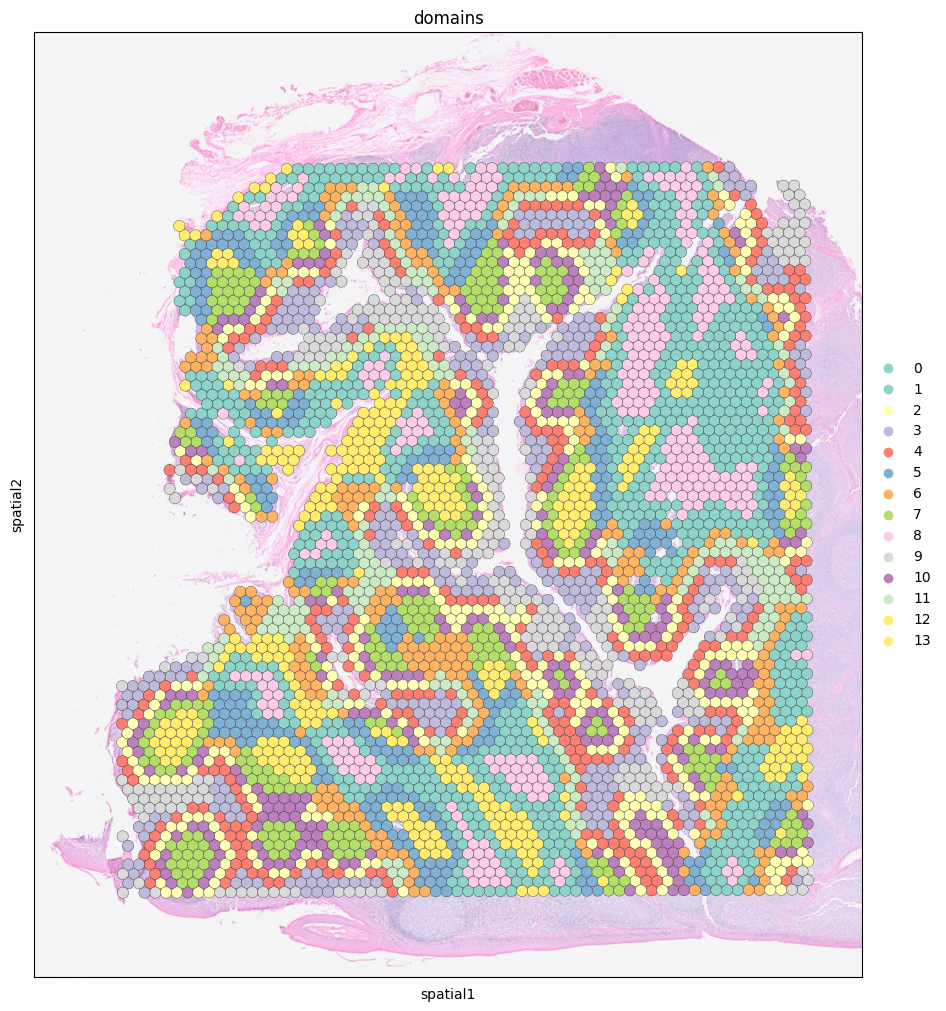

In [21]:
if 'domains_colors' in adata.uns: adata.uns.pop('domains_colors')
if 'leiden_colors' in adata.uns: adata.uns.pop('leiden_colors')
sq.pl.spatial_scatter(adata, color=['domains'], edgecolor='black', img_alpha=0.5, shape='circle', size=1.5, colorbar=False, 
                      crop_coord=tuple([0, 0, 28000, 40000]), figsize=(10, 10), linewidth = 0.2, palette='Set3',
                      dpi=100)